# 401k estimated gains calculation
Traditional 401k is contributed with pre-tax money, meaning your taxable income is reduced and you pay less taxes. However, when when you withdraw from your traditional 401k account, that money is taxed as ordinary income.

On the other hand, Roth 401k is contributed with post-tax money, meaning you would pay taxes now, and the gains on your 401k account are not taxed at withdrawl.

Should you contribute to traditional or Roth IRA? The rule of thumb is to guess your tax rate now vs at retirement, and choose accordingly. **But recently, another school of thought has emerged, claiming that if you invested the tax savings from traditional 401k, you'll come out ahead** of contributing to Roth. In this notebook, we explore whether this could be the case.


TL;DR - It turns out that this is mostly true:  maxing out traditional 401k account and investing the savings seems to be better than maxing out your Roth 401k account.

Assumptions
* Tax rate remains unchanged throughout the investment period.
* Biweekly contributions to the retirement account.
* Invested funds are compounded every two weeks, when contributions are made.
* Long term capital gains tax is constant at 15%.

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style("darkgrid")


Estimate your effective tax rate with [this website](https://smartasset.com/taxes/income-taxes#9bL2rosmk7).

As of Jan 2024, the effective tax rates in Massachusettes, Washington, and California are:

|Income ($)|Effective Rate (MA, %)|Effective Rate (WA, %)|Effective Rate (CA, %)|
|--|--|--|--|
|75,000|23.75| 19.33|24.07|
|100,000|26.47| 21.91|28.02|
|150,000|29.25| 25.03|32.05|
|250,000|32.25| 27.42|36.00|
|350,000|35.13| 30.26|39.33|

In [63]:

# assume we distribute our annual contribution over the entire year
# contribution is made every 2 weeks
def annual_contribution_with_growth(
    starting_balance=0, 
    annual_growth_rate=0.07, 
    annual_contribution = 22500,
    num_years=35,
    effective_tax_rate=0.2925
    ):
    """Estimation of gains and taxes contributed to a 401k account.
    
    Gains are compounded biweekly at a rate of annual_growth_rate/26. This is done to 
    account for biweekly contributions.
    
    Calculation is done assuming rate rates remain unchanged throughout the given time 
    period.
    
    Args:
        starting_balance: Starting balance in your 401k account at the start of year 0.
        annual_growth_rate: Estimated annual stock market growth rate, assumed to be constant
        annual_contribution: This annual contribution is divided into 26, assuming you contribute to 401k biweekly.
        num_years: Number of years you contribute to your 401k account.
        effective_tax_rate: Look up what your effective tax rate is. This is assumed to be constant across time.
        
    Returns:
        Dataframe with a summary of contributions, taxes, gains, etc, over the given amount of years.
    """
    
    num_paychecks_per_year = 26 # assume biweekly contribution and compounding
    total_contribution = 0
    biweekly_growth_rate = annual_growth_rate/num_paychecks_per_year
    num_weeks_total = num_years*num_paychecks_per_year
    biweekly_contribution = annual_contribution/num_paychecks_per_year
    taxes_every_two_weeks = biweekly_contribution*effective_tax_rate
    taxes_invested_end_balance = taxes_every_two_weeks # at time 0
    
    year = []
    total_principal = []
    year_start_balance = []
    year_end_balance = []
    taxes_invested_gains = []
    for week_num in range(num_weeks_total):
        total_contribution += biweekly_contribution
        end_balance = (biweekly_contribution+starting_balance)*(1+biweekly_growth_rate)
        
        # if we invested the taxes saved via traditional 401k
        taxes_invested_end_balance = (taxes_every_two_weeks+taxes_invested_end_balance)*(1+biweekly_growth_rate)
        
        # at start of year
        if np.mod(week_num,num_paychecks_per_year)==0:
            year.append(np.floor(week_num/num_paychecks_per_year).astype(int))
            year_start_balance.append(round(starting_balance))
        
        # at end of year
        if np.mod(week_num,num_paychecks_per_year)==(num_paychecks_per_year-1):
            total_principal.append(round(total_contribution))
            year_end_balance.append(round(end_balance))
            taxes_invested_gains.append(round(taxes_invested_end_balance,2))
            
        starting_balance = end_balance
        
    df = pd.DataFrame({
        "Year":year, 
        "Balance at Year Start":year_start_balance, 
        "Total Contributed": total_principal, 
        "Balance at Year End": year_end_balance,
        })
    df['Total Gains'] = df['Balance at Year End'] - df["Total Contributed"]
    df['Total Taxes Saved'] = df["Total Contributed"]*effective_tax_rate
    df['Taxes Invested (saved + gains)'] = taxes_invested_gains
    df['Gains From Taxes Invested'] = df["Taxes Invested (saved + gains)"] - df['Total Taxes Saved']
    
    return df.set_index("Year")

In [64]:
assumed_tax_rate = 0.3 # ordinary income tax rate.

# estimate the annual gains and taxes from biweekly contributions over time.
df = annual_contribution_with_growth(
    starting_balance=0, 
    annual_growth_rate=0.07, # average annual stock market growth rate
    annual_contribution = 22500,
    num_years=35,
    effective_tax_rate=assumed_tax_rate
    )
df.style.format("{:,.2f}")

,Balance at Year Start,Total Contributed,Balance at Year End,Total Gains,Total Taxes Saved,Taxes Invested (saved + gains),Gains From Taxes Invested
Year,,,,,,,
0,0.00,"22,500.00","23,336.00",836.00,"6,750.00","7,279.34",529.34
1,"23,336.00","45,000.00","48,363.00","3,363.00","13,500.00","14,807.35","1,307.35"
2,"48,363.00","67,500.00","75,201.00","7,701.00","20,250.00","22,880.44","2,630.44"
3,"75,201.00","90,000.00","103,982.00","13,982.00","27,000.00","31,538.09","4,538.09"
4,"103,982.00","112,500.00","134,848.00","22,348.00","33,750.00","40,822.61","7,072.61"
5,"134,848.00","135,000.00","167,948.00","32,948.00","40,500.00","50,779.39","10,279.39"
6,"167,948.00","157,500.00","203,445.00","45,945.00","47,250.00","61,457.12","14,207.12"
7,"203,445.00","180,000.00","241,513.00","61,513.00","54,000.00","72,908.00","18,908.00"
8,"241,513.00","202,500.00","282,337.00","79,837.00","60,750.00","85,188.00","24,438.00"


In [65]:
# What are your net gains at the end of the given time period?
final_year_data = df.iloc[-1]
net_gain_traditional_401k = (
    final_year_data['Balance at Year End']*(1-assumed_tax_rate) # Taxed as ordinary income
    + final_year_data['Taxes Invested (saved + gains)'] # Income from investing the taxes saved
    - final_year_data['Gains From Taxes Invested']*0.15 # Capital gains tax from taxes invested
    )
print(f'{net_gain_traditional_401k = :,.2f}')


net_gain_roth_401k = (
    final_year_data['Balance at Year End'] # amount in Roth retirement account are not taxed at withdrawl
    - final_year_data['Total Taxes Saved'] # taxes are paid up front
    )
print(f'{net_gain_roth_401k = :,.2f}')

net_gain_traditional_401k = 3,285,258.40
net_gain_roth_401k = 3,164,035.00


# Interim Conclusions
## Traditional 401k
At the end of 35 years, you'll have \\$3,400,285.00 in your account. When withdrawing, this money is taxed at ordinary income.
Assuming a tax rate of 30%, you'll have to pay \\$1,020,085 in taxes. This is substantially higher than the total amount of taxes you saved at end of year 35 (\\$230,343)
Your gains from taxes invested nets you \\$997,506. To use this money, I assume you'll need to pay 15% long term capital gains tax on \\$767,163.15, which is \\$115,074

So maxing out traditional 401k every year, at the end of the year 35, you have  \\$3,400,285.00 - \\$1,020,085 + \\$997,506 - \\$115,074 = \\$3,262,631

## Roth 401k
In this scenario, you'll also have \\$3,400,285.00 in your account after 35 years. This amount if not taxed when withdrawn, but you paid \\$230,343 of taxes up front, and you don't get to invest the taxes saved.
You end up with \\$3,400,285 - \\$230,343 = \\$3,169,942

## The winner
It would seem like maxing out the traditional 401k and investing the difference is a good idea. One of the main contributing factors is that **investing the taxes saved over the long run will cause them to be taxed at the long term capital gains rate (15%) as opposed to ordinary income taxes (30% or more).**



# How does this conclusion hold for different tax bracket and time periods?

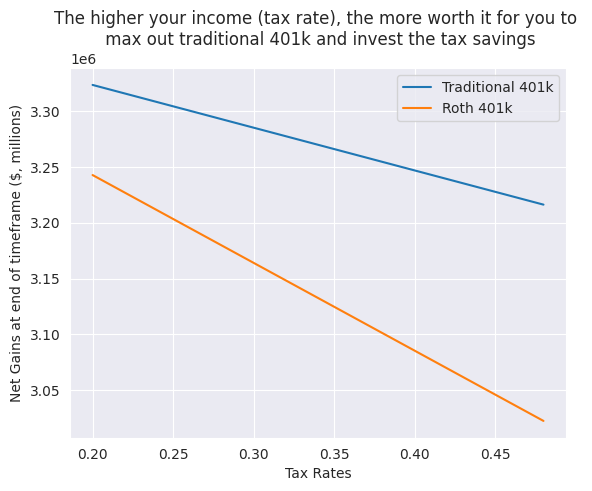

In [66]:
def vary_over_tax_rate(tax_rates):
    
    traditional=[]
    roth=[]
    for tax_rate in tax_rates:
        df = annual_contribution_with_growth(
            starting_balance=0, 
            annual_growth_rate=0.07, # average annual stock market growth rate
            annual_contribution = 22500,
            num_years=35,
            effective_tax_rate=tax_rate
            )
        
        # What are your net gains at the end of the given time period?
        final_year_data = df.iloc[-1]
        net_gain_traditional_401k = (
            final_year_data['Balance at Year End']*(1-tax_rate) # Taxed as ordinary income
            + final_year_data['Taxes Invested (saved + gains)'] # Income from investing the taxes saved
            - final_year_data['Gains From Taxes Invested']*0.15 # Capital gains tax from taxes invested
            )
        traditional.append(net_gain_traditional_401k)

        net_gain_roth_401k = (
            final_year_data['Balance at Year End'] # amount in Roth retirement account are not taxed at withdrawl
            - final_year_data['Total Taxes Saved'] # taxes are paid up front
            )
        roth.append(net_gain_roth_401k)
    
    plt.plot(tax_rates, traditional, label='Traditional 401k')    
    plt.plot(tax_rates, roth, label="Roth 401k")
    plt.xlabel("Tax Rates")
    plt.ylabel("Net Gains at end of timeframe ($, millions)")
    plt.legend()
    plt.title("The higher your income (tax rate), the more worth it for you to \n max out traditional 401k and invest the tax savings")
    plt.show()
        
vary_over_tax_rate(tax_rates = np.arange(0.2,0.5,0.02))

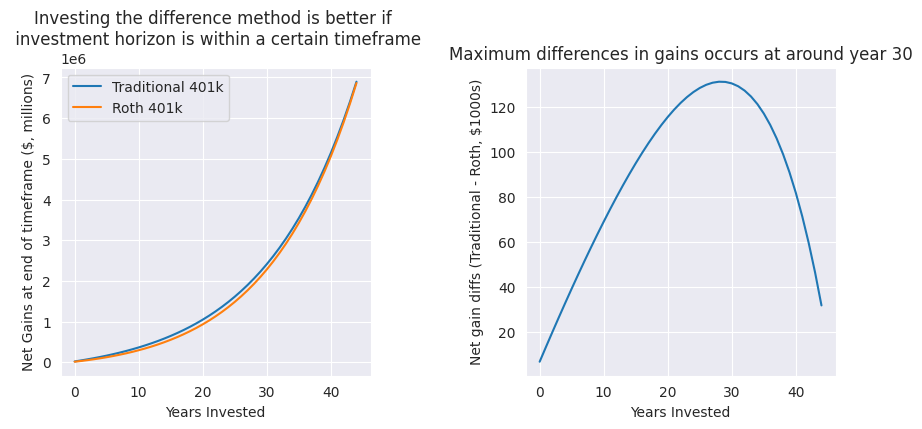

In [68]:
def vary_over_years(num_years):
    """Assume constant 30% tax rate"""
    
    traditional=[]
    roth=[]
    tax_rate = 0.3
    df = annual_contribution_with_growth(
        starting_balance=0, 
        annual_growth_rate=0.07, # average annual stock market growth rate
        annual_contribution = 22500,
        num_years=num_years,
        effective_tax_rate=tax_rate
        )
    
    years = np.arange(num_years)
    for year in years:
        # What are your net gains at the end of the given time period?
        final_year_data = df.iloc[year]
        net_gain_traditional_401k = (
            final_year_data['Balance at Year End']*(1-tax_rate) # Taxed as ordinary income
            + final_year_data['Taxes Invested (saved + gains)'] # Income from investing the taxes saved
            - final_year_data['Gains From Taxes Invested']*0.15 # Capital gains tax from taxes invested
            )
        traditional.append(net_gain_traditional_401k)

        net_gain_roth_401k = (
            final_year_data['Balance at Year End'] # amount in Roth retirement account are not taxed at withdrawl
            - final_year_data['Total Taxes Saved'] # taxes are paid up front
            )
        roth.append(net_gain_roth_401k)
    
    plt.figure(figsize = (10,4))
    plt.subplot(1,2,1)
    plt.plot(years, traditional, label='Traditional 401k')    
    plt.plot(years, roth, label="Roth 401k")
    plt.xlabel("Years Invested")
    plt.ylabel("Net Gains at end of timeframe ($, millions)")
    plt.legend()
    plt.title("Investing the difference method is better if \n investment horizon is within a certain timeframe")
    
    plt.subplot(1,2,2)
    plt.plot(years, (np.array(traditional)-np.array(roth))/1000)
    plt.ylabel("Net gain diffs (Traditional - Roth, $1000s)")
    plt.xlabel("Years Invested")
    plt.title("Maximum differences in gains occurs at around year 30")
    
    plt.subplots_adjust(wspace=0.5)
    plt.show()
        
vary_over_years(num_years=45)